In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import sys
import os

In [3]:
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
other_folder = os.path.join(parent_dir, 'app')
sys.path.append(other_folder)

In [4]:
from lib import *

Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.

Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.



In [5]:
shop_sales = pd.read_csv('../app/test_data/shop_sales.csv')
shop_sales_dates = pd.read_csv('../app/test_data/shop_sales_dates.csv')
shop_sales_prices = pd.read_csv('../app/test_data/shop_sales_prices.csv')

In [6]:
df = merge_files_to_dataset(shop_sales, shop_sales_prices, shop_sales_dates)

In [7]:
df = summ_sales_data(df, 'date', granularity = 'Day')

In [8]:
df = df_encoding(df)

In [9]:
df['date'].max()

Timestamp('2016-01-21 00:00:00')

In [10]:
df['item_id'].unique()

array(['STORE_2_085', 'STORE_2_043', 'STORE_2_054', 'STORE_2_325',
       'STORE_2_090', 'STORE_2_252', 'STORE_2_376', 'STORE_2_391',
       'STORE_2_524', 'STORE_2_555', 'STORE_2_586', 'STORE_2_587',
       'STORE_2_681', 'STORE_2_714', 'STORE_2_716', 'STORE_3_012',
       'STORE_3_114', 'STORE_3_357', 'STORE_3_360', 'STORE_3_090',
       'STORE_3_169', 'STORE_3_222', 'STORE_3_252', 'STORE_3_358',
       'STORE_3_389', 'STORE_3_555', 'STORE_3_586', 'STORE_3_587',
       'STORE_3_714', 'STORE_3_804', 'STORE_1_064', 'STORE_1_065',
       'STORE_1_325', 'STORE_1_376', 'STORE_1_090', 'STORE_1_252',
       'STORE_1_339', 'STORE_1_546', 'STORE_1_547', 'STORE_1_555',
       'STORE_1_584', 'STORE_1_586', 'STORE_1_587', 'STORE_1_714',
       'STORE_1_727'], dtype=object)

In [11]:
data_prediction, model, horizont = get_preds(df, ['STORE_2_714'], 5)

запуск первого шага
new var_for_add ! month_lag_5
едем дальше
в итоге получили список ['month_lag_5']
запуск первого шага
new var_for_add ! weekday_Tuesday_lag_5
едем дальше
в итоге получили список ['month_lag_5', 'weekday_Tuesday_lag_5']
запуск первого шага
new var_for_add ! weekday_Monday_lag_5
едем дальше
в итоге получили список ['month_lag_5', 'weekday_Tuesday_lag_5', 'weekday_Monday_lag_5']
запуск первого шага
new var_for_add ! year_lag_5
едем дальше
в итоге получили список ['month_lag_5', 'weekday_Tuesday_lag_5', 'weekday_Monday_lag_5', 'year_lag_5']
запуск первого шага
new var_for_add ! cnt_EMA_3_lag_5
new var_for_add ! CASHBACK_STORE_3_lag_5
едем дальше
в итоге получили список ['month_lag_5', 'weekday_Tuesday_lag_5', 'weekday_Monday_lag_5', 'year_lag_5', 'CASHBACK_STORE_3_lag_5']
запуск первого шага
мы сошлись
['month_lag_5', 'weekday_Tuesday_lag_5', 'weekday_Monday_lag_5', 'year_lag_5', 'CASHBACK_STORE_3_lag_5']
279608274301042.7



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [12]:
data_prediction

,month_lag_5,weekday_Tuesday_lag_5,weekday_Monday_lag_5,year_lag_5,CASHBACK_STORE_3_lag_5,mean,cnt_SMA_3_lag_5,item_id,date,cnt,model_prediction,arima_prediction
0,12.0,0.0,0.0,2015.0,1.0,19.611111,20.333333,STORE_2_714,2015-12-17,25.0,21.967215,22.457300
1,12.0,0.0,0.0,2015.0,1.0,19.611111,25.333333,STORE_2_714,2015-12-18,24.0,21.967215,24.864768
2,12.0,0.0,1.0,2015.0,0.0,19.611111,28.333333,STORE_2_714,2015-12-19,25.0,29.559018,24.443709
3,12.0,1.0,0.0,2015.0,1.0,19.611111,24.000000,STORE_2_714,2015-12-20,37.0,31.429766,24.850907
4,12.0,0.0,0.0,2015.0,0.0,19.611111,20.666667,STORE_2_714,2015-12-21,14.0,20.880093,29.983240
5,12.0,0.0,0.0,2015.0,0.0,19.611111,20.000000,STORE_2_714,2015-12-22,32.0,20.880093,20.474397
6,12.0,0.0,0.0,2015.0,0.0,19.611111,22.666667,STORE_2_714,2015-12-23,21.0,20.880093,27.871930
7,12.0,0.0,0.0,2015.0,0.0,19.611111,24.666667,STORE_2_714,2015-12-24,18.0,20.880093,23.358921
8,12.0,0.0,0.0,2015.0,0.0,19.611111,28.666667,STORE_2_714,2015-12-25,0.0,20.880093,21.971518
9,12.0,0.0,1.0,2015.0,0.0,19.611111,25.333333,STORE_2_714,2015-12-26,22.0,29.559018,14.104614


In [13]:
result = evaluate_predictions(data_prediction, horizont)

In [14]:
result.Prediction

0    model_prediction
1     cnt_SMA_3_lag_5
2                mean
3    arima_prediction
Name: Prediction, dtype: object

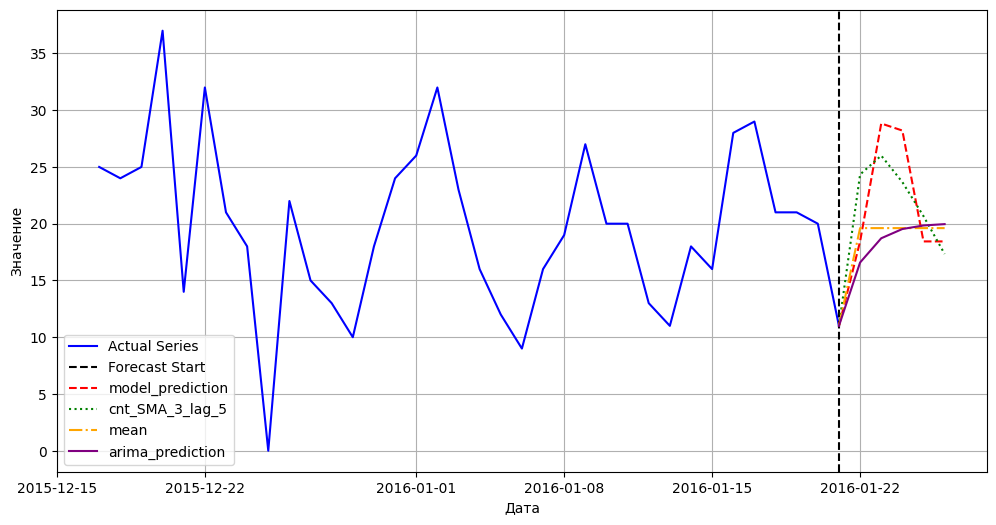

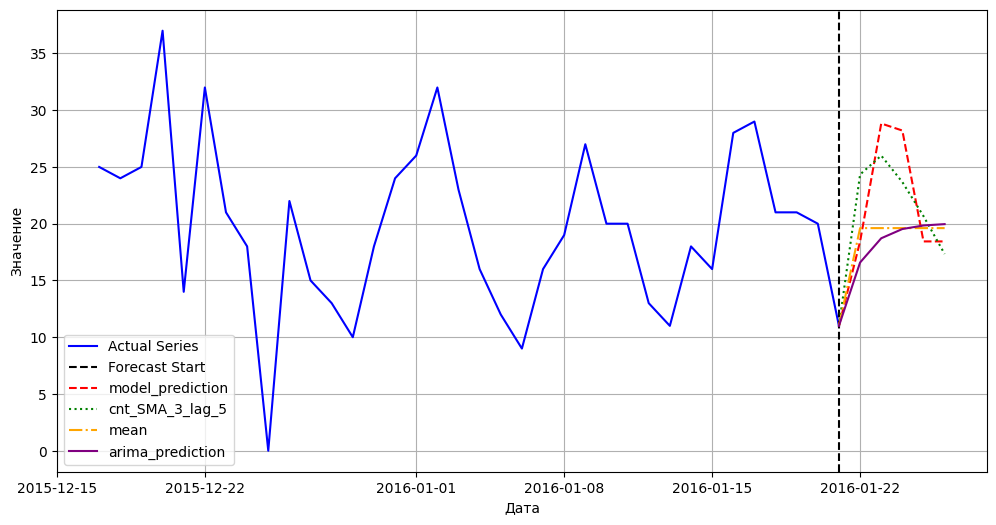

In [15]:
forecast_plot_from_df(data_prediction, 'date', 'cnt', ['model_prediction', 'cnt_SMA_3_lag_5', 'mean', 'arima_prediction'])